In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from tqdm import tqdm_notebook as tqdm
import pathlib
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor, plot_importance
from sklearn.decomposition import PCA
from sklearn import linear_model

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)     
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
RS = 2734
DATA_DIR = pathlib.Path("./")

In [98]:
train_data = pd.read_csv(DATA_DIR.joinpath("activity_train.csv"),
                         parse_dates=["date"], index_col="date")
test_data = pd.read_csv(DATA_DIR.joinpath("activity_test.csv"),
                        parse_dates=["date"], index_col="date")
activity_test_target = pd.read_csv(DATA_DIR.joinpath("activity_test_timestamps.csv"),
                                   index_col="date",
                                   parse_dates=["date"])
atactic_test_target = pd.read_csv(DATA_DIR.joinpath("atactic_test_timestamps.csv"),
                                   index_col="date",
                                   parse_dates=["date"])

In [99]:
atactic_train = train_data[['atactic_1', 'atactic_1', 'atactic_1']].dropna()

In [100]:
data = pd.concat([train_data, test_data], sort = False).drop('f28', axis = 1)

In [101]:
df_train = atactic_train.merge(data, on = 'date', how = 'left')

In [102]:
df_train = df_train.drop(['atactic_1_x', 'atactic_1_x', 'atactic_1_x'], axis = 1)

In [103]:
df_train.rename(columns = {'atactic_1_y':'atactic_1'}, inplace = True) 

In [104]:
atactic_test_target['atactic_1'] = np.nan
atactic_test_target['atactic_2'] = np.nan
atactic_test_target['atactic_3'] = np.nan

In [105]:
df_test = atactic_test_target.merge(test_data, on = 'date', how = 'left')

In [106]:
df_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f50,f51,f52,f53,f54,f55,activity,atactic_1,atactic_2,atactic_3
date,,,,,,,,,,,,,,,,,,,,,
2018-02-14 08:00:00,50.623959,295.093024,1.630123,0.000043,0.022583,0.001564,1.716432e+06,694263.536388,1.276742,0.411108,...,342.99463,332.76154,332.71643,483.874202,9210.350990,541.657805,34.088139,7.7,7.9,7.5
2018-02-15 08:00:00,75.799500,294.906308,1.512484,0.000050,0.018128,0.001471,1.722896e+06,702577.822508,1.255756,0.570202,...,343.01434,332.52112,332.50296,527.408302,1813.298941,8393.776894,42.191756,7.3,7.5,7.1
2018-02-16 08:00:00,38.187050,294.822127,1.689199,0.000052,0.023153,0.001558,1.704581e+06,722688.508551,1.230210,0.523069,...,342.95792,332.38007,332.37347,8850.371361,2658.471107,522.594094,36.451201,6.9,7.4,6.7
2018-02-17 08:00:00,31.270189,294.450955,1.680241,0.000051,0.023985,0.001647,1.721319e+06,731304.641775,1.202683,0.525487,...,342.98718,332.56210,332.51843,7409.225941,492.020488,882.627428,33.908764,6.7,6.9,7.1
2018-02-18 08:00:00,33.000511,291.286286,1.683453,0.000051,0.024333,0.001636,1.727909e+06,740552.105402,1.185679,0.519711,...,342.95383,332.66104,332.63617,6173.758030,521.066785,6850.787163,29.804776,6.5,7.0,7.3


In [113]:
df_train.fillna(method = 'ffill', inplace = True)

In [107]:
df_test.head()

,atactic_1,atactic_2,atactic_3,f0,f1,f2,f3,f4,f5,f6,...,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 08:00:00,NaN,NaN,NaN,45.202621,294.853819,1.635692,0.000052,0.020059,0.001907,1.716121e+06,...,336.37436,336.43228,336.36700,336.48663,343.00560,333.20160,333.14923,1550.076008,8322.487831,533.768177
2019-01-02 08:00:00,NaN,NaN,NaN,35.841068,293.997330,1.641888,0.000052,0.019600,0.001895,1.709315e+06,...,336.60953,336.66425,336.49130,336.60986,342.99470,333.60507,333.52740,7983.892918,544.251621,2156.280994
2019-01-03 08:00:00,NaN,NaN,NaN,25.122709,294.274439,1.661174,0.000052,0.027428,0.001865,1.711030e+06,...,336.99940,337.05255,336.81326,336.93140,342.99940,333.92767,333.88065,519.990802,4418.312073,5588.274956
2019-01-04 08:00:00,NaN,NaN,NaN,25.147301,294.182860,1.653976,0.000053,0.020764,0.001886,1.708161e+06,...,336.41516,336.47064,336.07867,336.16480,342.99762,332.42203,332.36353,5555.266857,4837.512016,533.909976
2019-01-05 08:00:00,NaN,NaN,NaN,49.725700,293.790511,1.659702,0.000053,0.020580,0.001926,1.705428e+06,...,336.94520,337.01070,336.48060,336.58408,343.02014,332.59247,332.56866,7614.645958,544.669211,1048.717976


In [ ]:
X = df.reset_index().drop('date', axis = 1)

X = X.dropna()

y = X['activity'].values
X = X.drop('activity',axis=1)

<h3> Regression

In [ ]:
def mape(y, y_pred): 
    y, y_pred = np.array(y), np.array(y_pred)
    return np.mean(np.abs((y - y_pred) / y)) * 100

#X = StandardScaler().fit_transform(X)
#y = np.log10(y)

MAPE = make_scorer(mape, greater_is_better = False)

In [ ]:
def lets_try(train_, target):
    results={}
    def test_model(clf):
        
        cv = TimeSeriesSplit(n_splits = 4)
        MAPE = make_scorer(mape, greater_is_better = False)
        mape_val_score = cross_val_score(clf, train_, target, cv = cv, scoring = MAPE)
        scores = [mape_val_score.mean()]
        return scores
    
    clf = linear_model.LinearRegression()
    results["Linear"] = test_model(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"] = test_model(clf)
    
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"] = test_model(clf)
    
    clf = linear_model.HuberRegressor()
    results["Hubber"] = test_model(clf)
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"] = test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["MAPE score"] 
#    results=results.sort_values(columns = ["MAPE Score"], ascending=False)
    results.plot(kind = "bar",title = "Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5, 1])
    return results

lets_try(train_, target)

In [286]:
target = pd.DataFrame(train_data["activity"])

Text(0.5, 1.0, 'Activity')

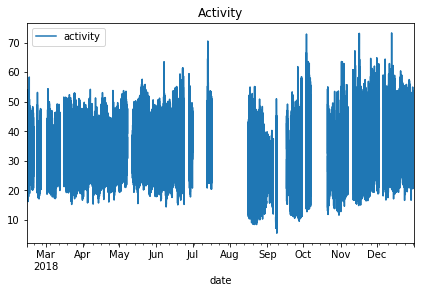

In [287]:
target['activity'].plot()
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

In [288]:
activity_data = target.join(data)
activity_data = activity_data[activity_data.notnull().all(axis = 1)]

In [289]:
X = activity_data.reset_index().drop('date', axis = 1)

X = X.dropna()

y = X['activity'].values
X = X.drop('activity',axis=1)

In [290]:
y

array([33.99816973, 34.62365945, 33.96948276, ..., 45.38970385,
       45.54252189, 45.06096939])

In [291]:
X.shape

(306550, 55)

<h3> PCA + Regressions

In [292]:
def mape(y, y_pred): 
    y, y_pred = np.array(y), np.array(y_pred)
    return np.mean(np.abs((y - y_pred) / y)) * 100

#X = StandardScaler().fit_transform(X)
#y = np.log10(y)

MAPE = make_scorer(mape, greater_is_better = False)

In [293]:
l = X.columns.tolist()
#l.remove('const')

In [294]:
train_data = train_data.drop(['f28','atactic_1','atactic_2','atactic_3'], axis=1)
test_data = test_data.drop('f28',axis=1)

test_data['activity'] = np.nan

In [295]:
df = train_data.append(test_data)

In [296]:
test = df[df.index >= '2019-01-01'][l]

In [297]:
test = activity_test_target.merge(test, how = 'inner', left_index=True, right_index=True).drop(['f3', 'f53', 'f55'], axis = 1)

In [298]:
l.append('activity')
train = df[l].dropna().drop(['f3', 'f53', 'f55'], axis = 1)

In [299]:
target = train['activity']

In [300]:
target = np.log10(train['activity'])

In [304]:
train_and_test = train.append(test)

In [309]:
train_and_test = train_and_test.drop('activity', axis = 1)

In [308]:
train_and_test[306550:]

,activity,f0,f1,f10,f11,f12,f13,f14,f15,f16,...,f49,f5,f50,f51,f52,f54,f6,f7,f8,f9
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:30:00,NaN,57.132648,294.708041,1.646756,0.000050,0.021358,0.001885,728283.785888,2.957360,0.620547,...,336.16528,0.001852,343.03546,333.43230,333.38052,2178.483009,1.716315e+06,743388.392658,2.989328,0.591614
2019-01-01 00:31:00,NaN,57.119122,294.702589,1.646189,0.000050,0.021372,0.001898,728682.523340,2.957156,0.620651,...,336.19940,0.001874,343.03375,333.41724,333.36392,1944.569945,1.715817e+06,741369.594337,2.989310,0.591480
2019-01-01 00:32:00,NaN,57.079891,294.718029,1.646378,0.000050,0.021417,0.001899,728362.953532,2.957269,0.620666,...,336.40747,0.001874,343.01495,333.37753,333.29938,1710.854053,1.716210e+06,743306.512832,2.989467,0.591614
2019-01-01 00:33:00,NaN,57.057171,294.718260,1.646029,0.000050,0.021639,0.001874,729521.288871,2.957300,0.620600,...,336.23605,0.001885,342.99408,333.36500,333.30533,1476.246953,1.715934e+06,741396.762914,2.989151,0.591434
2019-01-01 00:34:00,NaN,57.040150,294.744400,1.646264,0.000050,0.021805,0.001880,727673.451511,2.957208,0.620388,...,336.46835,0.001895,342.97284,333.34850,333.30220,1239.382029,1.716098e+06,744469.664631,2.989379,0.591440
2019-01-01 00:35:00,NaN,56.973549,294.755410,1.646298,0.000050,0.021637,0.001888,728630.150179,2.957253,0.620443,...,336.45050,0.001905,342.95276,333.33838,333.29870,1005.396008,1.715973e+06,741361.551315,2.989275,0.591536
2019-01-01 00:36:00,NaN,56.957790,294.752409,1.646240,0.000050,0.021921,0.001898,728616.355462,2.957161,0.620395,...,336.40580,0.001901,342.96716,333.35345,333.30072,776.264429,1.716489e+06,742753.695410,2.989448,0.591457
2019-01-01 00:37:00,NaN,56.936680,294.754959,1.644759,0.000050,0.021712,0.001899,730906.091370,2.957437,0.620435,...,336.57306,0.001900,342.98468,333.37488,333.34045,595.982194,1.716005e+06,743735.551899,2.989470,0.591457
2019-01-01 00:38:00,NaN,56.899830,294.734949,1.645646,0.000050,0.021795,0.001900,729424.819378,2.957397,0.620367,...,336.22470,0.001901,342.98465,333.42093,333.37160,547.762871,1.715803e+06,743267.186199,2.989411,0.591417


In [312]:
#PCA train
pca = PCA(whiten = True)
pca.fit(train_and_test)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

array([0.49775984, 0.76141842, 0.88747689, 0.94966771, 0.99163569,
       0.99707778, 0.99944326, 0.99999964, 0.99999978, 0.99999989,
       0.99999997, 0.99999998, 0.99999999, 0.99999999, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [313]:
pca = PCA(n_components = 16, whiten = True)
pca = pca.fit(train_and_test)
dataPCA = pca.transform(train_and_test)

In [314]:
train_ = dataPCA[:306550]

In [315]:
test_ = dataPCA[306550:]

In [236]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [237]:
train.shape

(306550, 52)

,MAPE score
Linear,-3.632172
Ridge,-3.632064
Bayesian Ridge,-3.628760
Hubber,-3.620936
Lasso,-3.599247
Bagging,-4.189901


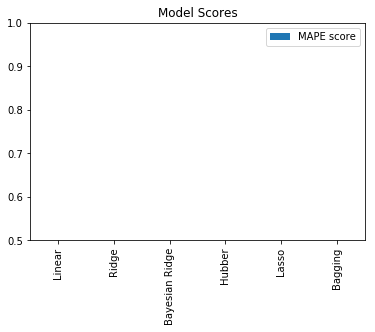

In [239]:
def lets_try(train_, target):
    results={}
    def test_model(clf):
        
        cv = TimeSeriesSplit(n_splits = 4)
        MAPE = make_scorer(mape, greater_is_better = False)
        mape_val_score = cross_val_score(clf, train_, target, cv = cv, scoring = MAPE)
        scores=[mape_val_score.mean()]
        return scores
    
    clf = linear_model.LinearRegression()
    results["Linear"] = test_model(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"] = test_model(clf)
    
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"] = test_model(clf)
    
    clf = linear_model.HuberRegressor()
    results["Hubber"] = test_model(clf)
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"] = test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["MAPE score"] 
    results.plot(kind = "bar", title = "Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5, 1])
    return results

lets_try(train_, target)

In [322]:
model = Lasso()
model.fit(train_, target)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [323]:
preds = model.predict(test_)

In [326]:
predictions = 10 ** preds

In [328]:
submit = activity_test_target.copy()
submit['activity'] = predictions
submit.to_csv('катализатор_15.csv')

In [86]:
preds = 10**res

In [87]:
preds.shape

(85891,)

In [93]:
submit = activity_test_target.copy()
submit['activity'] = preds
submit.to_csv('катализатор_10.csv')